In [301]:
#Load data into sqlite database
import sys
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=sys.maxsize)

In [15]:
#define a few functions 

# Functions to use to add taxonomy codes to nppes

def add_taxonomy(dataframe):
    result_values = {}
    for i in range(1, 16):
        codes_columns = f'Healthcare Provider Taxonomy Code_{i}'
        switch_columns = f'Healthcare Provider Primary Taxonomy Switch_{i}'
        
        # Check the condition and append values to the result list
        keys = dataframe['NPI'][dataframe[switch_columns]=='Y'].tolist()
        values = dataframe[codes_columns][dataframe[switch_columns]=='Y']
        for key, value in zip(keys,values):
            result_values[key] = value
            
    taxonomy_df = pd.DataFrame(list(result_values.items()), columns=['NPI', 'Taxonomy_Code'])
    nppes_merged = dataframe.merge(taxonomy_df, on = 'NPI', how = 'left')
    return nppes_merged
                


# function to clean up zipcodes

def Convert_strings_to_nan(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

# def fix_zipcode(series):
#     # fill na with zeroes
#     #change to int so the zeroes at the end gets removed
#     # then change to strings and use zfill to add leading zeroes
#     series = series.fillna(0).astype(float).astype(int).astype(str).str.zfill(5)
#     # now i can split the strings at 5th item
#     return series.str[:5]

# New Function that takes care of the 8 digit zipcodes
def fix_zipcode(series):
    series = pd.to_numeric(series, errors = 'coerce')
    series = series.fillna(0)
    # create a new series with zipcodes
    new_series = series.apply(lambda x : str(int(x)).zfill(9) if len(str(int(x)))>5 else str(x).zfill(5))    
    # now i can split the strings at 5th item
    return new_series.str[:5]



columns_to_keep = ['NPI', 
                   'Entity Type Code', 
                   'Provider Organization Name (Legal Business Name)',
                   'Provider Last Name (Legal Name)',
                    'Provider First Name',
                    'Provider Middle Name',
                    'Provider Name Prefix Text',
                    'Provider Name Suffix Text',
                    'Provider Credential Text',       
                    'Provider First Line Business Practice Location Address',
                    'Provider Second Line Business Practice Location Address',
                    'Provider Business Practice Location Address City Name',
                    'Provider Business Practice Location Address State Name',
                    'Provider Business Practice Location Address Postal Code',
                    "Healthcare Provider Taxonomy Code_1",
                    "Healthcare Provider Primary Taxonomy Switch_1",
                    "Healthcare Provider Taxonomy Code_2",
                    "Healthcare Provider Primary Taxonomy Switch_2",
                    "Healthcare Provider Taxonomy Code_3",
                    "Healthcare Provider Primary Taxonomy Switch_3",
                    "Healthcare Provider Taxonomy Code_4",
                    "Healthcare Provider Primary Taxonomy Switch_4",
                    "Healthcare Provider Taxonomy Code_5",
                    "Healthcare Provider Primary Taxonomy Switch_5",
                    "Healthcare Provider Taxonomy Code_6",
                    "Healthcare Provider Primary Taxonomy Switch_6",
                    "Healthcare Provider Taxonomy Code_7",
                    "Healthcare Provider Primary Taxonomy Switch_7",
                    "Healthcare Provider Taxonomy Code_8",
                    "Healthcare Provider Primary Taxonomy Switch_8",
                    "Healthcare Provider Taxonomy Code_9",
                    "Healthcare Provider Primary Taxonomy Switch_9",
                    "Healthcare Provider Taxonomy Code_10",
                    "Healthcare Provider Primary Taxonomy Switch_10",
                    "Healthcare Provider Taxonomy Code_11",
                    "Healthcare Provider Primary Taxonomy Switch_11",
                    "Healthcare Provider Taxonomy Code_12",
                    "Healthcare Provider Primary Taxonomy Switch_12",
                    "Healthcare Provider Taxonomy Code_13",
                    "Healthcare Provider Primary Taxonomy Switch_13",
                    "Healthcare Provider Taxonomy Code_14",
                    "Healthcare Provider Primary Taxonomy Switch_14",
                    "Healthcare Provider Taxonomy Code_15",
                    "Healthcare Provider Primary Taxonomy Switch_15"
                    ]

In [16]:
#load files
cbsa = pd.read_csv('../data/ZIP_CBSA.csv')
taxonomy_code_classification =  pd.read_csv('../data/nucc_taxonomy_240.csv')

In [17]:
#fix zipcodes in cbsa data

# do this manually because it is simpler.
cbsa['zipcodes'] = cbsa['ZIP'].apply(lambda x : str(x).zfill(9) if len(str(x))>5 else str(x).zfill(5)).str[:5]

#read the npi data in chunk, filter them by some conditions and then write to sql.
db = sqlite3.connect('../data/npidata.sqlite')
for chunk in pd.read_csv('../data/DocGraph_Hop_Teaming_2018.csv', 
                              chunksize = 10000):
    chunk = chunk[chunk['transaction_count']>50]
    chunk = chunk[chunk['average_day_wait']<50]
    chunk.to_sql('npi', 
                db, 
                if_exists = 'append', 
                index = False)  
    
db.execute('CREATE INDEX from_npi ON npi(from_npi)')
db.close()

In [18]:
# load the nppes data to sqlite database

db = sqlite3.connect('../data/npidata.sqlite')
for chunk in pd.read_csv('../data/npidata.csv',
                         low_memory=False, 
                          usecols= columns_to_keep,
                              chunksize = 10000):
    chunk_taxonomy = add_taxonomy(chunk)
    chunk_merged = pd.merge(left = chunk_taxonomy, 
                            right = taxonomy_code_classification[['Code', 'Classification']].set_index('Code'), 
                            how = 'left',
                            left_on = 'Taxonomy_Code',
                            right_index = True)
    # chunk_merged['Provider Business Practice Location Address Postal Code'] = chunk_merged['Provider Business Practice Location Address Postal Code'].apply(Convert_strings_to_nan)
    chunk_merged['zipcodes'] = fix_zipcode(chunk_merged['Provider Business Practice Location Address Postal Code'])
    
    chunk_merged_cbsa = pd.merge(left = chunk_merged, 
         right = cbsa[['zipcodes','CBSA']].set_index('zipcodes'), 
         how = 'left',
         left_on = 'zipcodes', 
         right_index = True)
    
    chunk_merged_cbsa['CBSA']= chunk_merged_cbsa['CBSA'].fillna(0).astype(int)
    
    chunk_merged_cbsa.to_sql('nppes', 
                db, 
                if_exists = 'append', 
                index = False)  

db.execute('CREATE INDEX nppes_npi ON nppes(NPI)')
db.close()

In [19]:
db = sqlite3.connect('../data/npidata.sqlite')

query = '''
SELECT *
FROM npi
'''

hop_teams_data = pd.read_sql(query,db)
db.close()

In [20]:
hop_teams_data

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1508085911,1730166125,58,67,23.925,43.923
1,1508167040,1730166125,51,51,28.196,52.876
2,1508863549,1730166125,340,391,18.302,42.422
3,1508867870,1730166125,50,79,12.658,26.402
4,1508011040,1730166224,132,145,8.579,28.053
...,...,...,...,...,...,...
33563179,1417037664,1497939599,36,106,19.330,42.407
33563180,1417194903,1497939599,22,70,16.629,30.598
33563181,1417406372,1497939599,21,65,20.123,37.750
33563182,1417064825,1497940605,75,79,10.418,34.744


In [21]:
db = sqlite3.connect('../data/npidata.sqlite')

query = '''
SELECT *
FROM nppes
'''

hop_teams_nppes = pd.read_sql(query,db)
db.close()

In [26]:
hop_teams_nppes.head()

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA
0,1679576722,1.0,None,WIEBE,DAVID,A,None,None,M.D.,3500 CENTRAL AVE,None,KEARNEY,NE,688472944.0,207X00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207X00000X,Orthopaedic Surgery,68847,28260
1,1588667638,1.0,None,PILCHER,WILLIAM,C,DR.,None,MD,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736.0,207RC0000X,Y,207RC0000X,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RC0000X,Internal Medicine,32204,27260
2,1497758544,2.0,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",None,None,None,None,None,None,3418 VILLAGE DR,None,FAYETTEVILLE,NC,283044552.0,251G00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,251G00000X,"Hospice Care, Community Based",28304,22180
3,1306849450,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
4,1215930367,1.0,None,GRESSOT,LAURENT,None,DR.,None,M.D.,17323 RED OAK DR,None,HOUSTON,TX,770901243.0,174400000X,N,207RH0003X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RH0003X,Internal Medicine,77090,26420


In [112]:
hop_teams_data

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1508085911,1730166125,58,67,23.925,43.923
1,1508167040,1730166125,51,51,28.196,52.876
2,1508863549,1730166125,340,391,18.302,42.422
3,1508867870,1730166125,50,79,12.658,26.402
4,1508011040,1730166224,132,145,8.579,28.053
...,...,...,...,...,...,...
33563179,1417037664,1497939599,36,106,19.330,42.407
33563180,1417194903,1497939599,22,70,16.629,30.598
33563181,1417406372,1497939599,21,65,20.123,37.750
33563182,1417064825,1497940605,75,79,10.418,34.744


In [113]:
hop_teams_nppes

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA
0,1679576722,1.0,None,WIEBE,DAVID,A,None,None,M.D.,3500 CENTRAL AVE,None,KEARNEY,NE,688472944.0,207X00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207X00000X,Orthopaedic Surgery,68847,28260
1,1588667638,1.0,None,PILCHER,WILLIAM,C,DR.,None,MD,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736.0,207RC0000X,Y,207RC0000X,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RC0000X,Internal Medicine,32204,27260
2,1497758544,2.0,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",None,None,None,None,None,None,3418 VILLAGE DR,None,FAYETTEVILLE,NC,283044552.0,251G00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,251G00000X,"Hospice Care, Community Based",28304,22180
3,1306849450,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
4,1215930367,1.0,None,GRESSOT,LAURENT,None,DR.,None,M.D.,17323 RED OAK DR,None,HOUSTON,TX,770901243.0,174400000X,N,207RH0003X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RH0003X,Internal Medicine,77090,26420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989945,1942064936,1.0,None,BAROCIO,VALERIE,None,None,None,None,600 N ARROWHEAD AVE,None,SAN BERNARDINO,CA,924011164.0,172V00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,172V00000X,Community Health Worker,92401,40140
8989946,1851155840,1.0,None,SHUFFETT,WILLIAM,THOMAS,MR.,None,None,3934 DIXIE HWY STE 201,None,LOUISVILLE,KY,402164163.0,101Y00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

In [40]:
db = sqlite3.connect('../data/npidata.sqlite')

query = """
SELECT * 
FROM nppes as np
join npi as n
on np.NPI = n.from_npi
WHERE np.CBSA = 34980

"""

nashville_hospital_data = pd.read_sql(query,db)
db.close()

## First, research which professionals are sending significant numbers of patients only to competitor hospitals (such as TriStar Centennial Medical Center).


### How do I identify the hospital a provider sent someone to?

#### Note: A specific hospital can have different NPI's because of multiple locations. Each location has a unique NPI

In [43]:
# Do hospitals have a specific NPI number?
facilities_df = nashville_hospital_data[nashville_hospital_data['Entity Type Code'] == 2.0]
facilities_df

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
1088,1245233220,2.0,"NORTHRIDGE SURGERY CENTER, LP",None,None,None,None,None,None,601 SAUNDERSVILLE RD,None,MADISON,TN,37075.0,261QA1903X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,261QA1903X,Clinic/Center,37075,34980,1245233220,1104202761,68,90,38.278,61.155
1089,1245233220,2.0,"NORTHRIDGE SURGERY CENTER, LP",None,None,None,None,None,None,601 SAUNDERSVILLE RD,None,MADISON,TN,37075.0,261QA1903X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,261QA1903X,Clinic/Center,37075,34980,1245233220,1124175914,73,78,0.551,4.869
1090,1245233220,2.0,"NORTHRIDGE SURGERY CENTER, LP",None,None,None,None,None,None,601 SAUNDERSVILLE RD,None,MADISON,TN,37075.0,261QA1903X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,261QA1903X,Clinic/Center,37075,34980,1245233220,1144222035,30,60,0.550,3.461
1091,1245233220,2.0,"NORTHRIDGE SURGERY CENTER, LP",None,None,None,None,None,None,601 SAUNDERSVILLE RD,None,MADISON,TN,37075.0,261QA1903X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,261QA1903X,Clinic/Center,37075,34980,1245233220,1215932413,393,617,0.527,6.737
1092,1245233220,2.0,"NORTHRIDGE SURGERY CENTER, LP",None,None,None,None,None,None,601 SAUNDERSVILLE RD,None,MADISON,TN,37075.0,261QA1903X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,261QA1903X,Clinic/Center,37075,34980,1245233220,1245306232,30,60,0.550,3.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238027,1225517014,2.0,HOSPITALIST MEDICINE PHYSICIANS OF OHIO - COLU...,None,None,None,None,None,None,5410 MARYLAND WAY STE 300,Non

In [170]:
nashville_hospital_data.groupby('Provider Organization Name (Legal Business Name)').sum()['patient_count']

C:\Users\kidsa\AppData\Local\Temp\ipykernel_36932\897394561.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nashville_hospital_data.groupby('Provider Organization Name (Legal Business Name)').sum()['patient_count']


Provider Organization Name (Legal Business Name)
(RIVERSIDE FAMILY MEDICINE)              5005
1ST CHOICE CHIROPRACTIC INC.               54
A1 HEALTHCARE                              22
ACCUPATH DIAGNOSTIC LABORATORIES INC    38481
ACCURATE HEALTHCARE, INC.               40683
                                        ...  
WOODBURY NURSING CENTER                   665
WOOSLEY CHIROPRACTIC REHABILITATION        80
WYTHE COUNTY COMMUNITY HOSPITAL LLC     11387
XAI FAMILY MEDICAL CLINIC                 262
XUHAN PC LLP                              295
Name: patient_count, Length: 1323, dtype: int64

In [126]:
facilities_df['Provider Organization Name (Legal Business Name)'].unique()

array(['NORTHRIDGE SURGERY CENTER, LP', 'CARIS HEALTHCARE, LP',
       'DICKSON MEDICAL ASSOCIATES PC', 'WEST MEADE PLACE LLP',
       'ANESTHESIA MEDICAL GROUP, PC',
       'COUNTY OF RUTHERFORD OFFICE OF BUDGET DIRECTOR',
       'AGILITAS USA INC', 'MCMINNVILLE DRUG CENTER INC',
       'WILLOWBROOK HOME HEALTH CARE AGENCY, INC.',
       'COMPREHENSIVE REHABILITATION OF LAFAYETTE INC',
       'WILLOWBROOK HOSPICE, INC.', 'LABORATORY FOR KIDNEY PATHOLOGY INC',
       'PHYSICIANS PAVILION LP', 'PAIN MANAGEMENT GROUP, P.C.',
       'AVALON HEALTH CARE, LLC', 'AVALON HEALTH CARE, LLC.',
       'RHA TENNESSEE GROUP HOMES',
       'SELECT SPECIALTY HOSPITAL - NASHVILLE LLC', 'COUNTY OF SUMNER',
       'COMMUNITY CARE OF RUTHERFORD COUNTY, INC.',
       'MIDDLE TENNESSEE FAMILY MEDICINE',
       'ODYSSEY HEALTHCARE OPERATING A, LP', 'MARSHALL COUNTY GOVERNMENT',
       'ENDOSCOPY CENTER OF ST THOMAS LLC',
       'NASHVILLE PLASTIC SURGERY INSTITUTE, PLLC',
       'FRANKLIN DERMATOLOGY GROUP,

In [144]:
# Create dataframe with vanderbilt entries
vanderbilt_df = \
facilities_df[facilities_df['Provider Organization Name (Legal Business Name)'] == 'VANDERBILT UNIVERSITY MEDICAL CENTER']

In [145]:
vanderbilt_df

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
91742,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1083657027,102,198,0.000,0.000
91743,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1093741464,45,56,36.679,43.543
91744,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1093768137,83,114,5.368,18.293
91745,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1306889597,101,156,12.712,30.687
91746,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1376634907,75,88,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236160,1972027159,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,N

In [109]:
nashville_hospital_data

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1134122187,1.0,None,RUDNICKE,CHERYL,DENISE,MRS.,None,CRNP,250 25TH AVE N,STE 412,NASHVILLE,TN,372031632.0,363L00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,363L00000X,Nurse Practitioner,37203,34980,1134122187,1568464873,52,52,21.327,21.192
1,1134122187,1.0,None,RUDNICKE,CHERYL,DENISE,MRS.,None,CRNP,250 25TH AVE N,STE 412,NASHVILLE,TN,372031632.0,363L00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,363L00000X,Nurse Practitioner,37203,34980,1134122187,1699713164,53,53,0.000,0.000
2,1134122187,1.0,None,RUDNICKE,CHERYL,DENISE,MRS.,None,CRNP,250 25TH AVE N,STE 412,NASHVILLE,TN,372031632.0,363L00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,363L00000X,Nurse Practitioner,37203,34980,1134122187,1750761060,53,53,0.000,0.000
3,1750384780,1.0,None,PERRIGIN,JULIE,A,DR.,None,MD,219 CHURCH ST,None,DICKSON,TN,370551303.0,207Q00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207Q00000X,Family Medicine,37055,34980,1750384780,1003863580,101,129,32.000,38.731
4,1750384780,1.0,None,PERRIGIN,JULIE,A,DR.,None,MD,219 CHURCH ST,None,DICKSON,TN,370551303.0,207Q00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207Q00000X,Family Medicine,37055,34980,1750384780,1013175215,31,61,4.639,25.993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238041,1184109134,1.0,None,SACHS,ALEXANDRA,NICOLE,None,None,DPT,1203B MEMORIAL BLVD,None,MURFREESBORO,TN,371292420.0,225100000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

**Make sure to make dictionary from original nppes and not the subsetted nashville_area_data**

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA
3,1306849450,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
38,1891798849,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
59,1770586729,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
104,1386647311,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
126,1427051457,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8980477,1992568653,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
8981017,1881457562,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
8981106,1386407088,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
8983855,1982467403,NaN,None,None,None,

In [163]:
hop_teams_nppes['Entity Type Code'].unique()

array([ 1.,  2., nan])

In [ ]:
# Subset data to facilities and providers
all_facilities = hop_teams_nppes[hop_teams_nppes['Entity Type Code'] == 2.0]
all_providers = hop_teams_nppes[hop_teams_nppes['Entity Type Code'] == 1.0]

# Filling all nulls with blank string
all_providers = all_providers.fillna('')
all_providers['Provider Full Name'] = \
all_providers['Provider Name Prefix Text'] + \
all_providers['Provider First Name'] + ' ' + \
all_providers['Provider Middle Name'] + ' ' + \
all_providers['Provider Last Name (Legal Name)'] + ' ' + \
all_providers['Provider Name Suffix Text'] + ' ' + \
all_providers['Provider Credential Text']

# Creating a dictionary for all the Business NPI's
npi_to_business = dict(zip(all_facilities['NPI'],all_facilities['Provider Organization Name (Legal Business Name)']))

# Creating a dictionary for all the Provider NPI's
npi_to_provider = dict(zip(all_providers['NPI'],all_providers['Provider Full Name']))

all_npi_classification = npi_to_business | npi_to_provider

In [172]:
# Subset data to facilities and providers
all_facilities = hop_teams_nppes[hop_teams_nppes['Entity Type Code'] == 2.0]
all_providers = hop_teams_nppes[hop_teams_nppes['Entity Type Code'] == 1.0]

In [175]:
# How many null values in dataframe
all_providers.isna().sum()

NPI                                                              0
Entity Type Code                                                 0
Provider Organization Name (Legal Business Name)           6815742
Provider Last Name (Legal Name)                                233
Provider First Name                                             62
Provider Middle Name                                       2949493
Provider Name Prefix Text                                  4627534
Provider Name Suffix Text                                  6698160
Provider Credential Text                                   2017286
Provider First Line Business Practice Location Address           7
Provider Second Line Business Practice Location Address    5734331
Provider Business Practice Location Address City Name            4
Provider Business Practice Location Address State Name          16
Provider Business Practice Location Address Postal Code          5
Healthcare Provider Taxonomy Code_1                           

In [177]:
# Filling all nulls with blank string
all_providers = all_providers.fillna('')

In [178]:
all_providers['Provider Full Name'] = \
all_providers['Provider Name Prefix Text'] + \
all_providers['Provider First Name'] + ' ' + \
all_providers['Provider Middle Name'] + ' ' + \
all_providers['Provider Last Name (Legal Name)'] + ' ' + \
all_providers['Provider Name Suffix Text'] + ' ' + \
all_providers['Provider Credential Text']

In [181]:
all_providers.head()

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,Provider Full Name
0,1679576722,1.0,,WIEBE,DAVID,A,,,M.D.,3500 CENTRAL AVE,,KEARNEY,NE,688472944.0,207X00000X,Y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,207X00000X,Orthopaedic Surgery,68847,28260,DAVID A WIEBE M.D.
1,1588667638,1.0,,PILCHER,WILLIAM,C,DR.,,MD,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736.0,207RC0000X,Y,207RC0000X,N,,,,,,,,,,,,,,,,,,,,,,,,,,,207RC0000X,Internal Medicine,32204,27260,DR.WILLIAM C PILCHER MD
4,1215930367,1.0,,GRESSOT,LAURENT,,DR.,,M.D.,17323 RED OAK DR,,HOUSTON,TX,770901243.0,174400000X,N,207RH0003X,Y,,,,,,,,,,,,,,,,,,,,,,,,,,,207RH0003X,Internal Medicine,77090,26420,DR.LAURENT GRESSOT M.D.
6,1932102084,1.0,,ADUSUMILLI,RAVI,K,,,MD,2940 N MCCORD RD,,TOLEDO,OH,436151753.0,207RC0000X,N,207RC0000X,Y,,,,,,,,,,,,,,,,,,,,,,,,,,,207RC0000X,Internal Medicine,43615,45780,RAVI K ADUSUMILLI MD
7,1841293990,1.0,,WORTSMAN,SUSAN,,,,MA-CCC,425 E 25TH ST,,NEW YORK,NY,100102547.0,231H00000X,Y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,231H00000X,Audiologist,10010,35620,SUSAN WORTSMAN MA-CCC


In [184]:
# Creating a dictionary for all the Business NPI's
npi_to_business = dict(zip(all_facilities['NPI'],all_facilities['Provider Organization Name (Legal Business Name)']))

# Creating a dictionary for all the Provider NPI's
npi_to_provider = dict(zip(all_providers['NPI'],all_providers['Provider Full Name']))

all_npi_classification = npi_to_business | npi_to_provider

In [67]:
#Creating a dictionary for all the Business NPI's
# npi_to_business = dict(zip(facilities_df['NPI'],facilities_df['Provider Organization Name (Legal Business Name)']))

# # Create dataframe of providers
# providers_df = nashville_hospital_data[nashville_hospital_data['Entity Type Code'] == 1.0]
# providers_df.shape

# providers_df.isna().sum()

# Filling all nulls with blank string
# providers_df = providers_df.fillna('')

# #Create a Full name Provider column
# providers_df['Full Name'] = \
# providers_df['Provider Name Prefix Text'] + \
# providers_df['Provider First Name'] + ' ' + \
# providers_df['Provider Middle Name'] + ' ' + \
# providers_df['Provider Last Name (Legal Name)'] + ' ' + \
# providers_df['Provider Name Suffix Text'] + ' ' + \
# providers_df['Provider Credential Text']

# providers_df.head()

# #Creating a dictionary for all the Provider NPI's
# npi_to_provider = dict(zip(providers_df['NPI'],providers_df['Full Name']))

# npi_to_provider

# npi_to_business

# all_npi_classification = npi_to_business | npi_to_provider

In [168]:
facilities_df['Provider Organization Name (Legal Business Name)'].unique()

array(['NORTHRIDGE SURGERY CENTER, LP', 'CARIS HEALTHCARE, LP',
       'DICKSON MEDICAL ASSOCIATES PC', 'WEST MEADE PLACE LLP',
       'ANESTHESIA MEDICAL GROUP, PC',
       'COUNTY OF RUTHERFORD OFFICE OF BUDGET DIRECTOR',
       'AGILITAS USA INC', 'MCMINNVILLE DRUG CENTER INC',
       'WILLOWBROOK HOME HEALTH CARE AGENCY, INC.',
       'COMPREHENSIVE REHABILITATION OF LAFAYETTE INC',
       'WILLOWBROOK HOSPICE, INC.', 'LABORATORY FOR KIDNEY PATHOLOGY INC',
       'PHYSICIANS PAVILION LP', 'PAIN MANAGEMENT GROUP, P.C.',
       'AVALON HEALTH CARE, LLC', 'AVALON HEALTH CARE, LLC.',
       'RHA TENNESSEE GROUP HOMES',
       'SELECT SPECIALTY HOSPITAL - NASHVILLE LLC', 'COUNTY OF SUMNER',
       'COMMUNITY CARE OF RUTHERFORD COUNTY, INC.',
       'MIDDLE TENNESSEE FAMILY MEDICINE',
       'ODYSSEY HEALTHCARE OPERATING A, LP', 'MARSHALL COUNTY GOVERNMENT',
       'ENDOSCOPY CENTER OF ST THOMAS LLC',
       'NASHVILLE PLASTIC SURGERY INSTITUTE, PLLC',
       'FRANKLIN DERMATOLOGY GROUP,

In [187]:
# Creating column that shows what facility/provider the patient was sent to
vanderbilt_df['to_business_provider'] = vanderbilt_df['to_npi'].map(all_npi_classification)

C:\Users\kidsa\AppData\Local\Temp\ipykernel_36932\4148042910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vanderbilt_df['to_business_provider'] = vanderbilt_df['to_npi'].map(all_npi_classification)


In [188]:
vanderbilt_df

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,to_business_provider
91742,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1083657027,102,198,0.000,0.000,SALEH AHMAD MD
91743,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1093741464,45,56,36.679,43.543,"ADVANCED DIAGNOSTIC IMAGING, PC"
91744,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1093768137,83,114,5.368,18.293,LEBANON HMA PHYSICIAN MANAGEMENT LLC
91745,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1306889597,101,156,12.712,30.687,VANDERBILT UNIVERSITY MEDICAL CENTER
91746,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1376634907,75,88,0.000,0.000,OLD HICKORY PSYCHIATRIC ASSN PLLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [189]:
vanderbilt_df.isna().sum()

NPI                                                           0
Entity Type Code                                              0
Provider Organization Name (Legal Business Name)              0
Provider Last Name (Legal Name)                            8650
Provider First Name                                        8650
Provider Middle Name                                       8650
Provider Name Prefix Text                                  8650
Provider Name Suffix Text                                  8650
Provider Credential Text                                   8650
Provider First Line Business Practice Location Address        0
Provider Second Line Business Practice Location Address    8506
Provider Business Practice Location Address City Name         0
Provider Business Practice Location Address State Name        0
Provider Business Practice Location Address Postal Code       0
Healthcare Provider Taxonomy Code_1                           0
Healthcare Provider Primary Taxonomy Swi

In [191]:
vanderbilt_df[vanderbilt_df['to_business_provider'].isna()]

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,to_business_provider
92640,1306889597,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1411 W. BADDOUR PARKWAY,None,LEBANON,TN,370872513.0,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37087,34980,1306889597,1457892614,100,125,39.752,59.781,NaN
155195,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DRIVE,None,NASHVILLE,TN,372320004.0,273R00000X,N,282N00000X,N,282NC2000X,N,283Q00000X,N,291U00000X,N,3416A0800X,N,3416L0300X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37232,34980,1396882205,1003175605,50,90,41.756,42.155,NaN
155208,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DRIVE,None,NASHVILLE,TN,372320004.0,273R00000X,N,282N00000X,N,282NC2000X,N,283Q00000X,N,291U00000X,N,3416A0800X,N,3416L0300X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37232,34980,1396882205,1013004142,135,208,3.904,13.113,NaN
155287,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DRIVE,None,NASHVILLE,TN,372320004.0,273R00000X,N,282N00000X,N,282NC2000X,N,283Q00000X,N,291U00000X,N,3416A0800X,N,3416L0300X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37232,34980,1396882205,1033537576,173,189,37.820,40.723,NaN
155507,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DRIVE,None,NASHVILLE,TN,372320004.0,273R00000X,N,282N00000X,N,282NC2000X,N,283Q00000X,N,291U00000X,N,3416A0800X,N,3416L0300X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37232,34980,1396882205,1101299992,574,581,0.000,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [222]:
vanderbilt_competitors = vanderbilt_df.groupby('to_business_provider').sum()['patient_count'].reset_index().sort_values(by = 'patient_count', ascending = False)
vanderbilt_competitors

C:\Users\kidsa\AppData\Local\Temp\ipykernel_36932\4088380818.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  vanderbilt_competitors = vanderbilt_df.groupby('to_business_provider').sum()['patient_count'].reset_index().sort_values(by = 'patient_count', ascending = False)


,to_business_provider,patient_count
4536,VANDERBILT UNIVERSITY MEDICAL CENTER,141151
26,"ADVANCED DIAGNOSTIC IMAGING, PC",35274
4087,SAINT THOMAS MEDICAL PARTNERS,21311
4379,TENNESSEE ONCOLOGY PLLC,17849
2797,LABORATORY CORPORATION OF AMERICA HOLDINGS,14207
...,...,...
836,DR.ABHAY G KEMKAR MD,13
1092,DR.DEBORAH J TYSON PHD,13
1293,DR.JENNIFER ANTHONY LEWIS M.D.,13
2428,"JAY SCHRODER, DC, LLC",13


### What is a competitor hospital

In [223]:
# Resetting the index
vanderbilt_competitors = vanderbilt_competitors.reset_index(drop = True)

# Removing the vanderbilt medical center because it's not a competitor 
vanderbilt_competitors = vanderbilt_competitors[vanderbilt_competitors['to_business_provider'] != 'VANDERBILT UNIVERSITY MEDICAL CENTER']

In [224]:
vanderbilt_competitors.head(50)

,to_business_provider,patient_count
1,"ADVANCED DIAGNOSTIC IMAGING, PC",35274
2,SAINT THOMAS MEDICAL PARTNERS,21311
3,TENNESSEE ONCOLOGY PLLC,17849
4,LABORATORY CORPORATION OF AMERICA HOLDINGS,14207
5,MAURY REGIONAL HOSPITAL,11965
6,WILLIAMSON COUNTY HOSPITAL DISTRICT,11845
7,HERITAGE MEDICAL ASSOCIATES PC,10008
8,"ONE HUNDRED OAKS IMAGING,LLC",8337
9,"VANDERBILT IMAGING SERVICES, LLC",8088
10,DAVID TABER MD,7588


In [230]:
vanderbilt_df

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,to_business_provider
91742,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1083657027,102,198,0.000,0.000,SALEH AHMAD MD
91743,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1093741464,45,56,36.679,43.543,"ADVANCED DIAGNOSTIC IMAGING, PC"
91744,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1093768137,83,114,5.368,18.293,LEBANON HMA PHYSICIAN MANAGEMENT LLC
91745,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1306889597,101,156,12.712,30.687,VANDERBILT UNIVERSITY MEDICAL CENTER
91746,1821030842,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273R00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273R00000X,Psychiatric Unit,37087,34980,1821030842,1376634907,75,88,0.000,0.000,OLD HICKORY PSYCHIATRIC ASSN PLLC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [236]:
# query = """
# SELECT * 
# FROM nppes as np
# join npi as n
# on np.NPI = n.from_npi
# WHERE np.CBSA = 34980

# """
# with sqlite3.connect('../data/npidata.sqlite') as db:
#     nppes_nashville = pd.read_sql(query, db)

# nppes_nashville.to_csv("../data/nppes_nashville.csv")

In [243]:
hop_teams_nppes

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA
0,1679576722,1.0,None,WIEBE,DAVID,A,None,None,M.D.,3500 CENTRAL AVE,None,KEARNEY,NE,688472944.0,207X00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207X00000X,Orthopaedic Surgery,68847,28260
1,1588667638,1.0,None,PILCHER,WILLIAM,C,DR.,None,MD,1824 KING STREET,SUITE 300,JACKSONVILLE,FL,322044736.0,207RC0000X,Y,207RC0000X,N,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RC0000X,Internal Medicine,32204,27260
2,1497758544,2.0,"CUMBERLAND COUNTY HOSPITAL SYSTEM, INC",None,None,None,None,None,None,3418 VILLAGE DR,None,FAYETTEVILLE,NC,283044552.0,251G00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,251G00000X,"Hospice Care, Community Based",28304,22180
3,1306849450,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,000.0,0
4,1215930367,1.0,None,GRESSOT,LAURENT,None,DR.,None,M.D.,17323 RED OAK DR,None,HOUSTON,TX,770901243.0,174400000X,N,207RH0003X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,207RH0003X,Internal Medicine,77090,26420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989945,1942064936,1.0,None,BAROCIO,VALERIE,None,None,None,None,600 N ARROWHEAD AVE,None,SAN BERNARDINO,CA,924011164.0,172V00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,172V00000X,Community Health Worker,92401,40140
8989946,1851155840,1.0,None,SHUFFETT,WILLIAM,THOMAS,MR.,None,None,3934 DIXIE HWY STE 201,None,LOUISVILLE,KY,402164163.0,101Y00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

In [292]:
query = """
SELECT * 
FROM nppes as np
join npi as n
on np.NPI = n.from_npi
WHERE np.CBSA = 34980
    AND [Provider Organization Name (Legal Business Name)] LIKE '%VANDERBILT%'

"""
with sqlite3.connect('../data/npidata.sqlite') as db:
    vanderbilt = pd.read_sql(query, db)
    

In [268]:
st_thomas['Provider Organization Name (Legal Business Name)'].unique()

array(['ENDOSCOPY CENTER OF ST THOMAS LLC',
       'SAINT THOMAS CAMPUS SURGICARE LP',
       'SAINT THOMAS OUTPATIENT NEUROSURGICAL CENTER',
       'SAINT THOMAS MEDICAL PARTNERS', 'SAINT THOMAS WEST HOSPITAL',
       'SAINT THOMAS HICKMAN HOSPITAL', 'SAINT THOMAS RX LLC',
       'SAINT THOMAS RUTHERFORD HOSPITAL',
       'SAINT THOMAS HOME HEALTH, INC.', 'SAINT THOMAS CLINIC PLLC',
       'SAINT THOMAS HEALTH', 'SAINT THOMAS HIGHLANDS HOSPITAL, LLC',
       'SAINT THOMAS RIVER PARK HOSPITAL, LLC',
       'SAINT THOMAS STONES RIVER HOSPITAL, LLC',
       'SAINT THOMAS DEKALB HOSPITAL, LLC', 'SAINT THOMAS CARE PLUS LLC'],
      dtype=object)

In [270]:
centennial['Provider Organization Name (Legal Business Name)'].unique()

array(['CENTENNIAL SURGERY CENTER LP',
       'COLUMBIA MEDICAL GROUP-CENTENNIAL INC',
       'CENTENNIAL SURGICAL ASSOCIATES LLC', 'CENTENNIAL HEART LLC',
       'CENTENNIAL PSYCHIATRIC ASSOCIATES, LLC',
       'CENTENNIAL NEUROSCIENCE, LLC', 'CENTENNIAL SURGICAL CLINIC, LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'CENTENNIAL HOSPITALISTS, LLC', 'CENTENNIAL WOMENS GROUP, LLC'],
      dtype=object)

In [272]:
tri_star['Provider Organization Name (Legal Business Name)'].unique()

array(['TRISTAR CARDIOVASCULAR SURGERY LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'TRISTAR RADIATION ONCOLOGY, LLC',
       'TRISTAR GYNECOLOGY ONCOLOGY, LLC',
       'TRISTAR JOINT REPLACEMENT INSTITUTE, LLC',
       'TRISTAR BONE MARROW TRANSPLANT, LLC', 'TRISTAR FAMILY CARE, LLC',
       'TRISTAR MEDICAL GROUP - LEGACY HEALTH, LLC'], dtype=object)

In [256]:
nashville['Provider Organization Name (Legal Business Name)'].unique()

array(['NASHVILLE GENERAL HOSPITAL'], dtype=object)

In [273]:
competitor_hospitals = ['ENDOSCOPY CENTER OF ST THOMAS LLC',
       'SAINT THOMAS CAMPUS SURGICARE LP',
       'SAINT THOMAS OUTPATIENT NEUROSURGICAL CENTER',
       'SAINT THOMAS MEDICAL PARTNERS', 'SAINT THOMAS WEST HOSPITAL',
       'SAINT THOMAS HICKMAN HOSPITAL', 'SAINT THOMAS RX LLC',
       'SAINT THOMAS RUTHERFORD HOSPITAL',
       'SAINT THOMAS HOME HEALTH, INC.', 'SAINT THOMAS CLINIC PLLC',
       'SAINT THOMAS HEALTH', 'SAINT THOMAS HIGHLANDS HOSPITAL, LLC',
       'SAINT THOMAS RIVER PARK HOSPITAL, LLC',
       'SAINT THOMAS STONES RIVER HOSPITAL, LLC',
       'SAINT THOMAS DEKALB HOSPITAL, LLC', 'SAINT THOMAS CARE PLUS LLC',
                        'CENTENNIAL SURGERY CENTER LP',
       'COLUMBIA MEDICAL GROUP-CENTENNIAL INC',
       'CENTENNIAL SURGICAL ASSOCIATES LLC', 'CENTENNIAL HEART LLC',
       'CENTENNIAL PSYCHIATRIC ASSOCIATES, LLC',
       'CENTENNIAL NEUROSCIENCE, LLC', 'CENTENNIAL SURGICAL CLINIC, LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'CENTENNIAL HOSPITALISTS, LLC', 'CENTENNIAL WOMENS GROUP, LLC', 'TRISTAR CARDIOVASCULAR SURGERY LLC',
       'TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CARE, LLC',
       'TRISTAR RADIATION ONCOLOGY, LLC',
       'TRISTAR GYNECOLOGY ONCOLOGY, LLC',
       'TRISTAR JOINT REPLACEMENT INSTITUTE, LLC',
       'TRISTAR BONE MARROW TRANSPLANT, LLC', 'TRISTAR FAMILY CARE, LLC',
                      'NASHVILLE GENERAL HOSPITAL' ]

In [294]:
vanderbilt['Provider Organization Name (Legal Business Name)'].unique()

array(['VANDERBILT STALLWORTH REHABILITATION HOSPITAL LP',
       'VANDERBILT UNIVERSITY MEDICAL CENTER',
       'VANDERBILT IMAGING SERVICES, LLC',
       'VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTER CLINICS AND SERVICES,',
       'VANDERBILT HOME CARE SERVICES, LLC',
       'VANDERBILT MAURY RADIATION ONCOLOGY, LLC'], dtype=object)

In [295]:
vanderbilt_hospitals = ['VANDERBILT STALLWORTH REHABILITATION HOSPITAL LP',
       'VANDERBILT UNIVERSITY MEDICAL CENTER',
       'VANDERBILT IMAGING SERVICES, LLC',
       'VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTER CLINICS AND SERVICES,',
       'VANDERBILT HOME CARE SERVICES, LLC',
       'VANDERBILT MAURY RADIATION ONCOLOGY, LLC']

In [276]:
vanderbilt_sent_patients = vanderbilt_df.groupby('to_business_provider')['patient_count'].sum().reset_index().sort_values(by = 'patient_count', ascending = False)

# Resetting the index
vanderbilt_sent_patients = vanderbilt_sent_patients.reset_index(drop = True)

vanderbilt_sent_patients.shape

(4688, 2)

In [285]:
vanderbilt_competitors = vanderbilt_sent_patients[vanderbilt_sent_patients['to_business_provider'].isin(competitor_hospitals)].reset_index(drop = True)
vanderbilt_competitors

,to_business_provider,patient_count
0,SAINT THOMAS MEDICAL PARTNERS,21311
1,SAINT THOMAS RUTHERFORD HOSPITAL,2251
2,SAINT THOMAS HICKMAN HOSPITAL,541
3,SAINT THOMAS WEST HOSPITAL,534
4,NASHVILLE GENERAL HOSPITAL,348
5,"SAINT THOMAS RIVER PARK HOSPITAL, LLC",344
6,TRISTAR MEDICAL GROUP - CENTENNIAL PRIMARY CAR...,309
7,"TRISTAR FAMILY CARE, LLC",197
8,CENTENNIAL SURGICAL ASSOCIATES LLC,159
9,"CENTENNIAL PSYCHIATRIC ASSOCIATES, LLC",133


In [288]:
vanderbilt_sent_patients.head(10)

,to_business_provider,patient_count
0,VANDERBILT UNIVERSITY MEDICAL CENTER,141151
1,"ADVANCED DIAGNOSTIC IMAGING, PC",35274
2,SAINT THOMAS MEDICAL PARTNERS,21311
3,TENNESSEE ONCOLOGY PLLC,17849
4,LABORATORY CORPORATION OF AMERICA HOLDINGS,14207
5,MAURY REGIONAL HOSPITAL,11965
6,WILLIAMSON COUNTY HOSPITAL DISTRICT,11845
7,HERITAGE MEDICAL ASSOCIATES PC,10008
8,"ONE HUNDRED OAKS IMAGING,LLC",8337
9,"VANDERBILT IMAGING SERVICES, LLC",8088


In [290]:
vanderbilt_sent_patients['patient_count'].sum()

1844192

In [300]:
vandy_sent_vandy = vanderbilt_sent_patients[vanderbilt_sent_patients['to_business_provider'].isin(vanderbilt_hospitals)].reset_index(drop = True)
vandy_sent_vandy

,to_business_provider,patient_count
0,VANDERBILT UNIVERSITY MEDICAL CENTER,141151
1,"VANDERBILT IMAGING SERVICES, LLC",8088
2,VANDERBILT HEALTH AND WILLIAMSON MEDICAL CENTE...,6380
3,"VANDERBILT HOME CARE SERVICES, LLC",1530
4,VANDERBILT STALLWORTH REHABILITATION HOSPITAL LP,837
5,"VANDERBILT MAURY RADIATION ONCOLOGY, LLC",71


Note: The total patient count is 1,844,192

In [318]:
sorted_vanderbilt = vanderbilt_competitors.sort_values(by = 'patient_count', ascending = True)

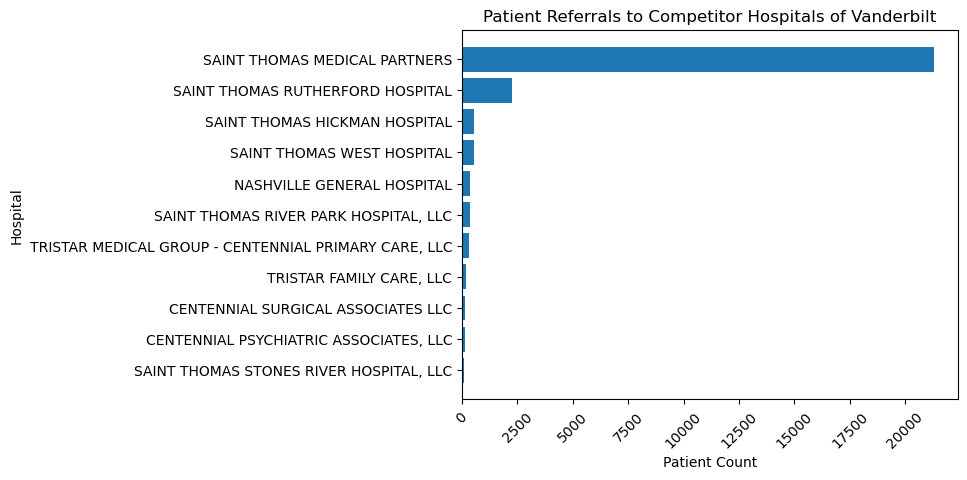

In [320]:
#Create bar graph of patient referral to competitor hospitals
plt.barh(data = sorted_vanderbilt, y = 'to_business_provider', width = 'patient_count')

plt.xticks(rotation = 45)

plt.xlabel('Patient Count')
plt.ylabel('Hospital')
plt.title('Patient Referrals to Competitor Hospitals of Vanderbilt')

plt.show()

In [323]:
#Subsetting patient referrals to top 10
top_10_vandy_referrals = vanderbilt_sent_patients.head(10).sort_values(by = 'patient_count', ascending = True)

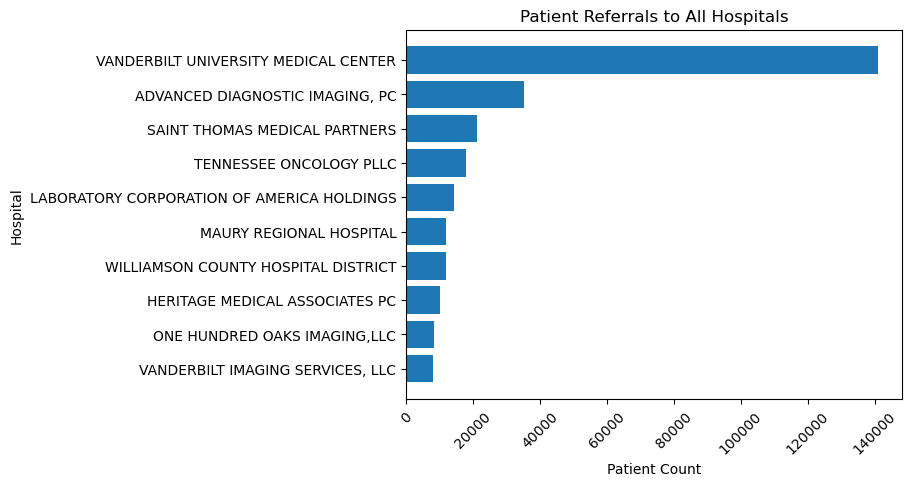

In [336]:
#Create bar graph of patient referral to all hospitals (Top 10)
plt.barh(data = top_10_vandy_referrals, y = 'to_business_provider', width = 'patient_count')

plt.xticks(rotation = 45)

plt.xlabel('Patient Count')
plt.ylabel('Hospital')
plt.title("Patient Referrals to All Hospitals")

plt.show()

In [331]:
#Take out all vanderbilt hospitals
top_10_no_vandy = vanderbilt_sent_patients[~vanderbilt_sent_patients['to_business_provider'].isin(vanderbilt_hospitals)] \
.head(10) \
.sort_values(by = 'patient_count', ascending = True)

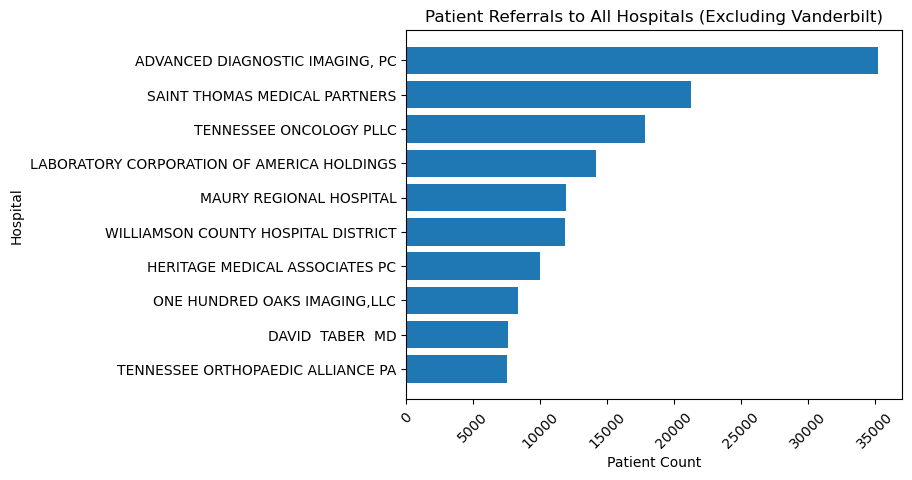

In [337]:
#Create bar graph of patient referral to all hospitals (Top 10 & excluding Vandy)
plt.barh(data = top_10_no_vandy, y = 'to_business_provider', width = 'patient_count')

plt.xticks(rotation = 45)

plt.xlabel('Patient Count')
plt.ylabel('Hospital')
plt.title('Patient Referrals to All Hospitals (Excluding Vanderbilt)')

plt.show()

- What percentage do they send to facilities and what percentage to providers
- What percentage are sent to competitor hospitals/ vandy/ other
- Regarding the patient referrals to Saint Thomas Medical Center are they being sent to a certain specialty?

In [341]:
vandy_to_st_thomas_med = vanderbilt_df[vanderbilt_df['to_business_provider'] == 'SAINT THOMAS MEDICAL PARTNERS']
vandy_to_st_thomas_med

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,to_business_provider
91859,1215979190,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273Y00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273Y00000X,Rehabilitation Unit,37087,34980,1215979190,1437194669,62,63,47.905,57.816,SAINT THOMAS MEDICAL PARTNERS
92630,1306889597,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1411 W. BADDOUR PARKWAY,None,LEBANON,TN,370872513.0,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37087,34980,1306889597,1437194669,1779,2773,31.874,49.270,SAINT THOMAS MEDICAL PARTNERS
154901,1558408633,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1601 23RD AVE S,None,NASHVILLE,TN,372123133.0,283Q00000X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37212,34980,1558408633,1437194669,246,354,48.847,57.330,SAINT THOMAS MEDICAL PARTNERS
156680,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1211 MEDICAL CENTER DRIVE,None,NASHVILLE,TN,372320004.0,273R00000X,N,282N00000X,N,282NC2000X,N,283Q00000X,N,291U00000X,N,3416A0800X,N,3416L0300X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37232,34980,1396882205,1437194669,7247,10319,45.911,54.884,SAINT THOMAS MEDICAL PARTNERS
226181,1104202761,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1301 22ND AVE S,None,NASHVILLE,TN,372325100.0,204E00000X,N,204F00000X,N,207L00000X,N,207P00000X,N,207Q00000X,N,207V00000X,N,207W00000X,N,207X00000X,N,207Y00000X,N,208000000X,N,2084N0400X,N,2084P0800X,N,2085R0202X,N,208600000X,N,207R00000X,Y,207R00000X,Internal Medicine,37232,34980,1104202761,1437194669,11919,17785,43.211,53.873,SAINT THOMAS MEDI

In [360]:
senders_to_vandy_comp = vanderbilt_df[vanderbilt_df['to_business_provider'].isin(competitor_hospitals)]

# Which classification of 
classification_to_comp = senders_to_vandy_comp.groupby('Classification')['patient_count'].sum().reset_index()

,Classification,patient_count
0,General Acute Care Hospital,10418
1,Internal Medicine,15669
2,Pharmacy,58
3,Rehabilitation Unit,62


In [ ]:
vanderbilt

In [370]:
vanderbilt_df['Classification'].unique()

array(['Psychiatric Unit', 'Rehabilitation Unit',
       'General Acute Care Hospital', 'Clinic/Center',
       'Internal Medicine', 'Pharmacy'], dtype=object)

In [363]:
senders_to_vandy_comp

,NPI,Entity Type Code,Provider Organization Name (Legal Business Name),Provider Last Name (Legal Name),Provider First Name,Provider Middle Name,Provider Name Prefix Text,Provider Name Suffix Text,Provider Credential Text,Provider First Line Business Practice Location Address,Provider Second Line Business Practice Location Address,Provider Business Practice Location Address City Name,Provider Business Practice Location Address State Name,Provider Business Practice Location Address Postal Code,Healthcare Provider Taxonomy Code_1,Healthcare Provider Primary Taxonomy Switch_1,Healthcare Provider Taxonomy Code_2,Healthcare Provider Primary Taxonomy Switch_2,Healthcare Provider Taxonomy Code_3,Healthcare Provider Primary Taxonomy Switch_3,Healthcare Provider Taxonomy Code_4,Healthcare Provider Primary Taxonomy Switch_4,Healthcare Provider Taxonomy Code_5,Healthcare Provider Primary Taxonomy Switch_5,Healthcare Provider Taxonomy Code_6,Healthcare Provider Primary Taxonomy Switch_6,Healthcare Provider Taxonomy Code_7,Healthcare Provider Primary Taxonomy Switch_7,Healthcare Provider Taxonomy Code_8,Healthcare Provider Primary Taxonomy Switch_8,Healthcare Provider Taxonomy Code_9,Healthcare Provider Primary Taxonomy Switch_9,Healthcare Provider Taxonomy Code_10,Healthcare Provider Primary Taxonomy Switch_10,Healthcare Provider Taxonomy Code_11,Healthcare Provider Primary Taxonomy Switch_11,Healthcare Provider Taxonomy Code_12,Healthcare Provider Primary Taxonomy Switch_12,Healthcare Provider Taxonomy Code_13,Healthcare Provider Primary Taxonomy Switch_13,Healthcare Provider Taxonomy Code_14,Healthcare Provider Primary Taxonomy Switch_14,Healthcare Provider Taxonomy Code_15,Healthcare Provider Primary Taxonomy Switch_15,Taxonomy_Code,Classification,zipcodes,CBSA,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,to_business_provider
91859,1215979190,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,500 PARK AVENUE,None,LEBANON,TN,370873721.0,273Y00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,273Y00000X,Rehabilitation Unit,37087,34980,1215979190,1437194669,62,63,47.905,57.816,SAINT THOMAS MEDICAL PARTNERS
92630,1306889597,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1411 W. BADDOUR PARKWAY,None,LEBANON,TN,370872513.0,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37087,34980,1306889597,1437194669,1779,2773,31.874,49.270,SAINT THOMAS MEDICAL PARTNERS
92686,1306889597,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1411 W. BADDOUR PARKWAY,None,LEBANON,TN,370872513.0,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37087,34980,1306889597,1629025648,441,533,44.000,60.692,SAINT THOMAS WEST HOSPITAL
154901,1558408633,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1601 23RD AVE S,None,NASHVILLE,TN,372123133.0,283Q00000X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37212,34980,1558408633,1437194669,246,354,48.847,57.330,SAINT THOMAS MEDICAL PARTNERS
154913,1558408633,2.0,VANDERBILT UNIVERSITY MEDICAL CENTER,None,None,None,None,None,None,1601 23RD AVE S,None,NASHVILLE,TN,372123133.0,283Q00000X,N,282N00000X,Y,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,282N00000X,General Acute Care Hospital,37212,34980,1558408633,1629025648,93,114,49.439,55.794,SAINT THOMAS WEST HOSPITAL
155640,1396882205,2.0,VANDERBILT UNIVERSITY MEDICAL CENT